# ---------------------------------变分自编码器--------------------------------------------------------

## 是什么：
- 一种生成式模型
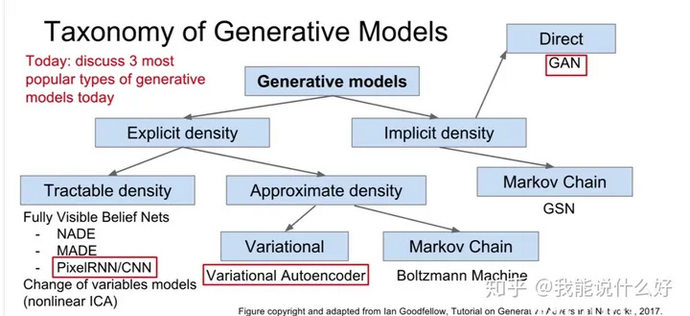

## 浅变量模型：
- 我们首先介绍什么是潜变量。顾名思义，潜变量就是观察不到的变量，这是相对于可观测变量而言的，比如说mnist数据集，可观测变量就是28x28维的图像变量。而我们认为，可观测变量是由潜变量产生的。我们记潜变量为z,可观测变量为x。举个例子，mnist数据中出现了一个手写数字7的图像，这个图像为什么会出现呢？我们认为，写这个数字的人首先脑子里想要写一个数字7，而写这个数字7需要什么元素呢？需要一横，一竖，同时这一横和一竖之间需要有一定的角度，这些元素就是所谓的潜变量，这个潜变量确定了，就能写出一个数字7。而我们观测到的只是这个数字7的图像，对应的潜变量则是不知道的。值得一提的是，稍微改变一下这个潜变量，也能得到一个数字7，比如说一横和一竖之间的角度稍微变化一点，对应的也是一个7，只不过和之前的7略有不同。数据集中每个数据点x都有一个相应的潜变量z，z通过某一个变换f(z,θ)可以得到x。θ是这个变换的参数。这就是所谓的潜变量模型。一个好的潜变量模型就在于，它的变换f(z,θ)能将潜变量的分布变换为观测数据X的分布。换句话说，它能使观测数据X的似然函数P(X)最大。如果我们能通过优化使得P(X)最大，那么就能得到这个潜变量模型了。这是极大似然法的思想。要想优化P(X)，我们首先需要得到它关于z和θ的表达式

- 这个积分的意思就是，比如说X是手写数字7的图像，我们就要把所有能产生7的隐变量z积起来。积分符号里面的第一项对应之前我们所说的变换f，在VAE中， ，把 表示为均值是f,方差是 的高斯分布这样一个概率形式的原因是，如果我们直接把 表达为f这样一个确定的变换函数形式，就无法在后面通过对 求导然后采用梯度下降的方式来优化参数θ（因为从概率的角度看，给定z和θ值，f唯一确定，此时对z积分后P(X)是一个delta冲激函数，他只在某一个x上有响应，这是不可导的，而形如高斯分布这样光滑的倒钟型曲线是可导的）

## VAE变分自编码器： 
- 一种潜变量模型
- 将传统自编码器学到得特征向量，换成学到一个分布，这个分布像是正态分布


In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
"""设置使用GPU计算"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
"""创建一个样本文件夹"""
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [4]:
"""设置超参数"""
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

In [5]:
"""加载MNIST数据集"""
dataset = torchvision.datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

In [6]:
"""打包用于训练得批量数据"""
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [7]:
"""定义VAE模型"""
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
    
    def encode(self, x):
        # 编码器知识一个线性层
        h = F.relu(self.fc1(x))
        # 结果返回两个值，一个是均值，一个是方差，直接线性层拟合得
        # 代表正态分布的两个参数
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        # std 是标准偏差，通过对数偏差 log_var计算得来
        std = torch.exp(log_var/2)
        # 根据标准偏差std，生成一个形状一样的随机噪声张量eps
        # torch.randn_like生成一个所有元素符合标准正态分布的于给定大小相同的张量
        eps = torch.randn_like(std)
        # 由于 eps 中的每个元素都是一个从标准正态分布中采样的随机数，而 std 描述了每个特征的变化程度，
        # 因此，z 中的每个元素就可以看作是从正态分布中采样得到的。
        # 返回的是从类似正态分布空间中的z取值
        # 这就是实现重参数技巧的过程
        return mu + eps * std
    
    def decode(self, z):
        # 解码器
        h = F.relu(self.fc4(z))
        # 返回通过线形层得到的解码值
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        # 定义前向传播
        # 计算编码器的两个层的值，分别为均值和方差
        mu, log_var = self.encode(x)
        # 利用重参数技巧，从类似的标准正态空间中取潜变量Z的值
        z = self.reparameterize(mu, log_var)
        # 返回解码器计算结果
        x_reconst = self.decode(z)
        
        return x_reconst, mu, log_var

In [8]:
"""实例化模型"""
model = VAE().to(device)

In [9]:
"""定义优化器"""
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
"""开始训练"""
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 前向传播
        # -1代表自动计算该维度的大小，也就是在图象前面加入一个batch_size维度， 如(a, b)，那么 .view(-1, c) 将把输入张量重塑为 (a * b, c)
        x = x.to(device).view(-1, image_size)
        
        x_reconst, mu, log_var = model(x)
        
        # 计算重构损失和KL散度
        # 二元交叉熵作为重构损失
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        # 这是计算KL散度的方法，也就是潜变量Z的正态分布和标准正态分布间的差异
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # 反向传播计算梯度和更新参数
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 打印训练进度
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
            
    with torch.no_grad():
        # 保存示例图片
        # 生成一个随机张量
        z = torch.randn(batch_size, z_dim).to(device)
        # 将模型结果重新调整成批量，通道，大小的形状
        out = model.decode(z).view(-1, 1, 28, 28)
        # 生成一组样本图象
        save_image(out, os.path.join(sample_dir, '随机生成-{}.png'.format(epoch+1)))
        
        # 根据样本图象进行重构
        out, _, _ = model(x)
        # 原始输入和重构的输出沿着第3维（颜色通道）连接起来，得到一个形状为 (batch_size, 2, 28, 28) 的张量 x_concat
        x = x.view(-1, 1, 28, 28)
        save_image(x, os.path.join(sample_dir, '训练样本x-{}.png'.format(epoch+1)))
        out = out.view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, '根据训练样本x的生成-{}.png'.format(epoch+1)))              


Epoch[1/15], Step [10/469], Reconst Loss: 9985.3369, KL Div: 3251.5225
Epoch[1/15], Step [20/469], Reconst Loss: 10164.4824, KL Div: 3305.2979
Epoch[1/15], Step [30/469], Reconst Loss: 9980.6895, KL Div: 3202.2578
Epoch[1/15], Step [40/469], Reconst Loss: 10001.1641, KL Div: 3274.9790
Epoch[1/15], Step [50/469], Reconst Loss: 9574.7520, KL Div: 3111.0205
Epoch[1/15], Step [60/469], Reconst Loss: 10145.6016, KL Div: 3252.1760
Epoch[1/15], Step [70/469], Reconst Loss: 9892.9912, KL Div: 3301.7349
Epoch[1/15], Step [80/469], Reconst Loss: 10309.6113, KL Div: 3315.9475
Epoch[1/15], Step [90/469], Reconst Loss: 10382.7422, KL Div: 3181.0532
Epoch[1/15], Step [100/469], Reconst Loss: 10097.5117, KL Div: 3254.3271
Epoch[1/15], Step [110/469], Reconst Loss: 10235.5938, KL Div: 3276.5195
Epoch[1/15], Step [120/469], Reconst Loss: 10089.6670, KL Div: 3265.4067
Epoch[1/15], Step [130/469], Reconst Loss: 10504.1836, KL Div: 3254.5244
Epoch[1/15], Step [140/469], Reconst Loss: 10534.4316, KL Div: 3

Epoch[3/15], Step [250/469], Reconst Loss: 10125.6943, KL Div: 3202.0806
Epoch[3/15], Step [260/469], Reconst Loss: 10072.6543, KL Div: 3298.3687
Epoch[3/15], Step [270/469], Reconst Loss: 10312.3184, KL Div: 3218.5205
Epoch[3/15], Step [280/469], Reconst Loss: 10349.1279, KL Div: 3315.8865
Epoch[3/15], Step [290/469], Reconst Loss: 10027.0586, KL Div: 3223.5737
Epoch[3/15], Step [300/469], Reconst Loss: 9697.9863, KL Div: 3321.2527
Epoch[3/15], Step [310/469], Reconst Loss: 9652.0449, KL Div: 3184.4531
Epoch[3/15], Step [320/469], Reconst Loss: 10162.1816, KL Div: 3157.3711
Epoch[3/15], Step [330/469], Reconst Loss: 9721.5547, KL Div: 3290.7651
Epoch[3/15], Step [340/469], Reconst Loss: 9961.8945, KL Div: 3280.2939
Epoch[3/15], Step [350/469], Reconst Loss: 10029.1221, KL Div: 3237.4875
Epoch[3/15], Step [360/469], Reconst Loss: 9906.6934, KL Div: 3262.2759
Epoch[3/15], Step [370/469], Reconst Loss: 10339.5264, KL Div: 3165.2622
Epoch[3/15], Step [380/469], Reconst Loss: 9950.1777, KL

Epoch[5/15], Step [460/469], Reconst Loss: 9631.6963, KL Div: 3258.4583
Epoch[6/15], Step [10/469], Reconst Loss: 10199.2891, KL Div: 3375.0984
Epoch[6/15], Step [20/469], Reconst Loss: 10201.7637, KL Div: 3256.4033
Epoch[6/15], Step [30/469], Reconst Loss: 10207.4941, KL Div: 3202.1589
Epoch[6/15], Step [40/469], Reconst Loss: 10219.2393, KL Div: 3292.5669
Epoch[6/15], Step [50/469], Reconst Loss: 9642.9854, KL Div: 3252.6130
Epoch[6/15], Step [60/469], Reconst Loss: 9919.7422, KL Div: 3193.9026
Epoch[6/15], Step [70/469], Reconst Loss: 9688.6465, KL Div: 3173.1611
Epoch[6/15], Step [80/469], Reconst Loss: 10536.9717, KL Div: 3398.8889
Epoch[6/15], Step [90/469], Reconst Loss: 9747.1992, KL Div: 3260.9966
Epoch[6/15], Step [100/469], Reconst Loss: 10109.2168, KL Div: 3285.7795
Epoch[6/15], Step [110/469], Reconst Loss: 10056.6152, KL Div: 3204.9009
Epoch[6/15], Step [120/469], Reconst Loss: 9783.1113, KL Div: 3296.0405
Epoch[6/15], Step [130/469], Reconst Loss: 10236.5605, KL Div: 330

Epoch[8/15], Step [240/469], Reconst Loss: 10089.1777, KL Div: 3173.0146
Epoch[8/15], Step [250/469], Reconst Loss: 10299.7617, KL Div: 3350.2705
Epoch[8/15], Step [260/469], Reconst Loss: 9627.0039, KL Div: 3180.0977
Epoch[8/15], Step [270/469], Reconst Loss: 9789.5234, KL Div: 3245.7930
Epoch[8/15], Step [280/469], Reconst Loss: 9907.5488, KL Div: 3282.2122
Epoch[8/15], Step [290/469], Reconst Loss: 10083.7402, KL Div: 3214.2188
Epoch[8/15], Step [300/469], Reconst Loss: 10616.2412, KL Div: 3287.9824
Epoch[8/15], Step [310/469], Reconst Loss: 9758.7852, KL Div: 3285.1692
Epoch[8/15], Step [320/469], Reconst Loss: 10432.7412, KL Div: 3310.9365
Epoch[8/15], Step [330/469], Reconst Loss: 10312.0352, KL Div: 3254.8669
Epoch[8/15], Step [340/469], Reconst Loss: 9353.5625, KL Div: 3174.0142
Epoch[8/15], Step [350/469], Reconst Loss: 9972.6123, KL Div: 3260.1033
Epoch[8/15], Step [360/469], Reconst Loss: 10105.4102, KL Div: 3263.1431
Epoch[8/15], Step [370/469], Reconst Loss: 9713.5176, KL 

Epoch[10/15], Step [460/469], Reconst Loss: 9916.4092, KL Div: 3311.1509
Epoch[11/15], Step [10/469], Reconst Loss: 9674.9258, KL Div: 3316.8022
Epoch[11/15], Step [20/469], Reconst Loss: 9696.8174, KL Div: 3215.5942
Epoch[11/15], Step [30/469], Reconst Loss: 9654.0889, KL Div: 3243.3716
Epoch[11/15], Step [40/469], Reconst Loss: 9385.7793, KL Div: 3118.0369
Epoch[11/15], Step [50/469], Reconst Loss: 9824.8271, KL Div: 3251.3384
Epoch[11/15], Step [60/469], Reconst Loss: 10005.7578, KL Div: 3243.0366
Epoch[11/15], Step [70/469], Reconst Loss: 10003.6270, KL Div: 3270.4846
Epoch[11/15], Step [80/469], Reconst Loss: 10060.9326, KL Div: 3207.7939
Epoch[11/15], Step [90/469], Reconst Loss: 9485.5303, KL Div: 3205.5029
Epoch[11/15], Step [100/469], Reconst Loss: 9947.8027, KL Div: 3314.4016
Epoch[11/15], Step [110/469], Reconst Loss: 9883.6816, KL Div: 3193.0054
Epoch[11/15], Step [120/469], Reconst Loss: 9716.2871, KL Div: 3134.5806
Epoch[11/15], Step [130/469], Reconst Loss: 9861.8477, KL

Epoch[13/15], Step [200/469], Reconst Loss: 10050.9482, KL Div: 3282.4106
Epoch[13/15], Step [210/469], Reconst Loss: 9775.1455, KL Div: 3137.9426
Epoch[13/15], Step [220/469], Reconst Loss: 10063.1660, KL Div: 3187.8552
Epoch[13/15], Step [230/469], Reconst Loss: 9895.2910, KL Div: 3240.9539
Epoch[13/15], Step [240/469], Reconst Loss: 10096.1641, KL Div: 3314.5994
Epoch[13/15], Step [250/469], Reconst Loss: 10184.3223, KL Div: 3367.5574
Epoch[13/15], Step [260/469], Reconst Loss: 10473.8213, KL Div: 3355.7056
Epoch[13/15], Step [270/469], Reconst Loss: 9997.0635, KL Div: 3299.8125
Epoch[13/15], Step [280/469], Reconst Loss: 9444.2480, KL Div: 3158.2747
Epoch[13/15], Step [290/469], Reconst Loss: 10140.9141, KL Div: 3211.7205
Epoch[13/15], Step [300/469], Reconst Loss: 9493.4863, KL Div: 3261.1343
Epoch[13/15], Step [310/469], Reconst Loss: 9951.6211, KL Div: 3291.0115
Epoch[13/15], Step [320/469], Reconst Loss: 9996.5166, KL Div: 3201.0842
Epoch[13/15], Step [330/469], Reconst Loss: 9

Epoch[15/15], Step [410/469], Reconst Loss: 9742.1543, KL Div: 3175.7197
Epoch[15/15], Step [420/469], Reconst Loss: 9836.2783, KL Div: 3296.7217
Epoch[15/15], Step [430/469], Reconst Loss: 10164.7168, KL Div: 3296.9006
Epoch[15/15], Step [440/469], Reconst Loss: 9985.1797, KL Div: 3185.8433
Epoch[15/15], Step [450/469], Reconst Loss: 10382.6562, KL Div: 3326.8357
Epoch[15/15], Step [460/469], Reconst Loss: 10118.7959, KL Div: 3317.3469


# -----------针对改变输入大小的试验------------
```python
x = x.to(device).view(-1, image_size)
```
### 将原来从打包数据集提取的小批量数据[128-批量, 1-通道， 28-图像高， 28-图象宽]转化为[128-批量, 784=28*28*1]

In [14]:
for i, (x, _) in enumerate(data_loader):
    if i == 1:
        print(x.shape)

torch.Size([128, 1, 28, 28])


In [15]:
for i, (x, _) in enumerate(data_loader):
    if i == 1:
        x = x.to(device).view(-1, image_size) # 这个image_size必须和图象大小一样
        print(x.shape)

torch.Size([128, 784])
